This notebook will do sensitivity analysis of emulations but without using autoemulate, just using SALib functions

In [1]:
import os
import pandas as pd
from autoemulate.core.compare import AutoEmulate
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis
from ModularCirc import BatchRunner
import torch
from autoemulate.core.save import ModelSerialiser
from autoemulate.core.logging_config import get_configured_logger
import matplotlib.pyplot as plt

from SALib.analyze.sobol import analyze
from SALib.sample import saltelli

from comparative_gsa.utils import helpers
figsize = (9, 5)

In [2]:
param_filename = 'parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas'

n_samples = 2048

simulation_out_path = f'../outputs/simulations/output_{n_samples}_samples_{param_filename}/'

parameters_json_file = os.path.join(simulation_out_path, 'parameters.json')

# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(simulation_out_path, f'input_samples_{n_samples}.csv'))

# Load the summary statistics
summary_stats = pd.read_csv(os.path.join(simulation_out_path, f'simulations_summary.csv'))

output_to_emulate = 'p_ao_max'

emulators_path = os.path.join(simulation_out_path, 'emulators', output_to_emulate)

In [3]:
# Use ModularCirc's BatchRunner to condense parameter names. This requires setting up the sampler first.
br = BatchRunner()

br.setup_sampler(parameters_json_file)

br._parameters_2_sample

{'ao.r': (195.0, 325.0),
 'ao.c': (0.22499999999999998, 0.375),
 'art.r': (843.75, 1406.25),
 'art.c': (2.25, 3.75),
 'ven.r': (6.75, 11.25),
 'ven.c': (84.975, 141.625),
 'av.r': (4.5, 7.5),
 'mv.r': (3.0749999999999997, 5.125),
 'la.E_pas': (0.22499999999999998, 0.375),
 'la.E_act': (0.41250000000000003, 0.6875),
 'la.k_pas': (0.00666, 0.03),
 'lv.E_pas': (0.75, 1.25),
 'lv.E_act': (2.25, 3.75),
 'lv.k_pas': (0.00666, 0.03)}

In [4]:
# Get column names for parameters up to 'lv.k_pas'
parameter_names = list(input_params.columns[:input_params.columns.get_loc('lv.k_pas') + 1])

In [5]:
# Extract parameter names and bounds from the dictionary
parameters_range = br._parameters_2_sample

parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

parameter_bounds

[(195.0, 325.0),
 (0.22499999999999998, 0.375),
 (843.75, 1406.25),
 (2.25, 3.75),
 (6.75, 11.25),
 (84.975, 141.625),
 (4.5, 7.5),
 (3.0749999999999997, 5.125),
 (0.22499999999999998, 0.375),
 (0.41250000000000003, 0.6875),
 (0.00666, 0.03),
 (0.75, 1.25),
 (2.25, 3.75),
 (0.00666, 0.03)]

In [6]:
input_params[parameter_names].describe().loc[['min', 'max']].T.values

array([[1.95009360e+02, 3.24968450e+02],
       [2.25016387e-01, 3.74929696e-01],
       [8.43942520e+02, 1.40607246e+03],
       [2.25051515e+00, 3.74942921e+00],
       [6.75186317e+00, 1.12490771e+01],
       [8.49875840e+01, 1.41612348e+02],
       [4.50042159e+00, 7.49921509e+00],
       [3.07566720e+00, 5.12414863e+00],
       [2.25017103e-01, 3.74939615e-01],
       [4.12629484e-01, 6.87406403e-01],
       [6.66256078e-03, 2.99971163e-02],
       [7.50184989e-01, 1.24989723e+00],
       [2.25024322e+00, 3.74994031e+00],
       [6.66092637e-03, 2.99913355e-02]])

In [7]:
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': input_params[parameter_names].describe().loc[['min', 'max']].T.values,
}

if output_to_emulate == 'p_ao_max':
    ae_results = helpers.ae_load_result(os.path.join(emulators_path, 'MLP_0_20250820_160858'))
elif output_to_emulate == 'p_la_max':
    ae_results = helpers.ae_load_result(os.path.join(emulators_path, 'MLP_0_20250820_162654'))

In [8]:
param_values = saltelli.sample(problem, 4096*2, calc_second_order=True)
param_values.shape

/var/folders/rc/594kgpld1czfpr55m3_m1szw0000gr/T/ipykernel_95674/2667588959.py:1: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 4096*2, calc_second_order=True)


(245760, 14)

In [9]:
param_values = pd.DataFrame(param_values, columns=parameter_names)

In [10]:
param_values.describe().loc[['min', 'max']].T.values

array([[1.95017292e+02, 3.24960518e+02],
       [2.25025537e-01, 3.74920546e-01],
       [8.43976829e+02, 1.40603815e+03],
       [2.25060664e+00, 3.74933772e+00],
       [6.75213766e+00, 1.12488026e+01],
       [8.49910401e+01, 1.41608892e+02],
       [4.50060462e+00, 7.49903206e+00],
       [3.07579223e+00, 5.12402360e+00],
       [2.25026253e-01, 3.74930464e-01],
       [4.12646255e-01, 6.87389632e-01],
       [6.66398501e-03, 2.99956921e-02],
       [7.50215489e-01, 1.24986673e+00],
       [2.25033476e+00, 3.74984877e+00],
       [6.66235034e-03, 2.99899115e-02]])

In [11]:
# Instead, load the pre-existing problem definition and saltelli samples
problem_path = '../outputs/simulations/output_245760_samples_parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas/problem.pkl'

# Load the problem pickle file
import pickle
import pandas as pd
with open(problem_path, 'rb') as f:
    problem = pickle.load(f)

saltelli_samples_path = '../outputs/simulations/output_245760_samples_parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas/saltelli_samples.csv'
param_values = pd.read_csv(saltelli_samples_path)


In [12]:
problem

{'num_vars': 14,
 'names': ['ao.r',
  'ao.c',
  'art.r',
  'art.c',
  'ven.r',
  'ven.c',
  'av.r',
  'mv.r',
  'la.E_pas',
  'la.E_act',
  'la.k_pas',
  'lv.E_pas',
  'lv.E_act',
  'lv.k_pas'],
 'bounds': array([[1.95000000e+02, 3.24999996e+02],
        [2.25000007e-01, 3.74999993e-01],
        [8.43750051e+02, 1.40625000e+03],
        [2.25000011e+00, 3.74999994e+00],
        [6.75000004e+00, 1.12499995e+01],
        [8.49750003e+01, 1.41624995e+02],
        [4.50000008e+00, 7.49999965e+00],
        [3.07500007e+00, 5.12499994e+00],
        [2.25000008e-01, 3.74999990e-01],
        [4.12500030e-01, 6.87499985e-01],
        [6.66000059e-03, 2.99999983e-02],
        [7.50000038e-01, 1.25000000e+00],
        [2.25000008e+00, 3.74999997e+00],
        [6.66000117e-03, 2.99999989e-02]]),
 'sample_scaled': True}

In [13]:
# Turn x into a pytorch tensor
x = torch.tensor(param_values.values, dtype=torch.float32)

In [14]:
# Use the input file to predict with the emulator
y_pred = ae_results.model.predict(x)

# Turning the y_pred into numpy
y_pred_np = y_pred.detach().cpu().numpy().squeeze()

In [15]:
# Do the sobol_analyse for GSA
sobol_indices = analyze(problem, y_pred_np, calc_second_order=True)

/Users/lbokeria/projects/health_gc/cvd_net_project/comparative-gsa/venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


14


In [16]:
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis
from autoemulate.core.sensitivity_analysis import _sobol_results_to_df 

In [17]:
results = {
    output_to_emulate: sobol_indices
}

In [18]:
sobol_df = _sobol_results_to_df(results)

In [19]:
# Due to a bug in autoemulate plotting, we must swap ST and S1 rows.

# Get the indices of rows where index == 'ST'
mask_st = sobol_df['index'] == 'ST'
mask_s1 = sobol_df['index'] == 'S1'

# For those rows, change the index to be 'S1'
sobol_df.loc[mask_st, 'index'] = 'S1'

# For those rows, change the index to be 'ST'
sobol_df.loc[mask_s1, 'index'] = 'ST'

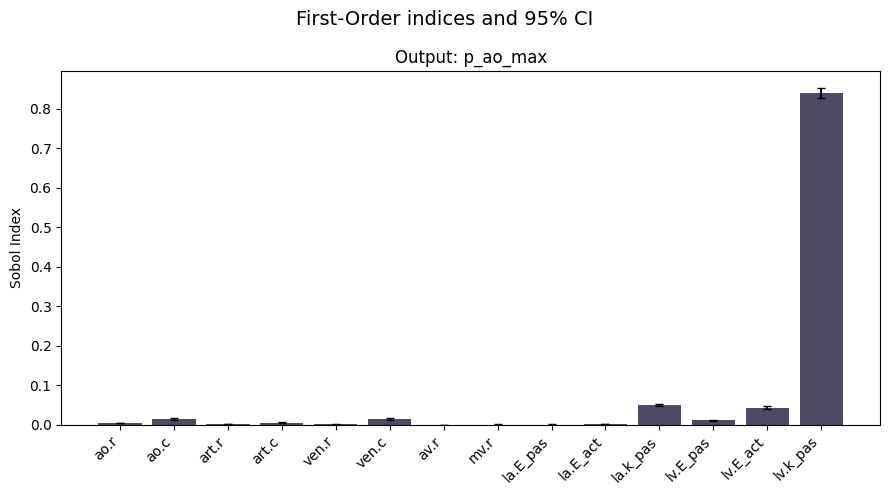

In [20]:
figsize = (9, 5)

SensitivityAnalysis.plot_sobol(sobol_df, index="S1", figsize=figsize) 

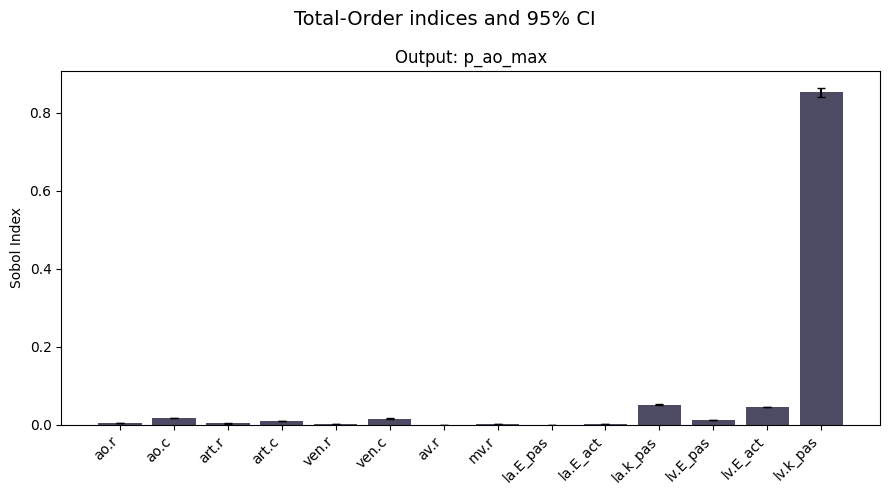

In [21]:
figsize = (9, 5)

SensitivityAnalysis.plot_sobol(sobol_df, index="ST", figsize=figsize) 

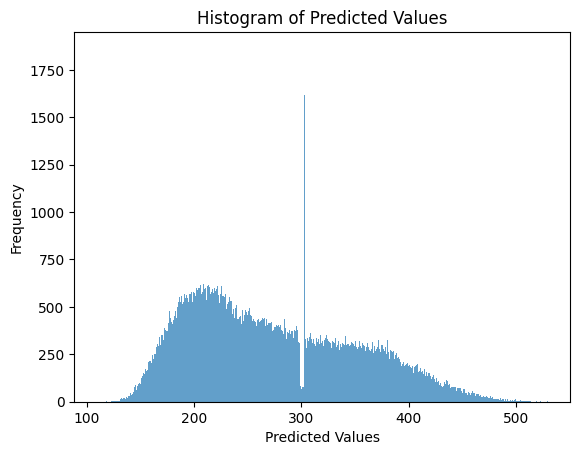

In [22]:
# Plot a histogram of y_pred_np
plt.hist(y_pred_np, bins=1000, alpha=0.7)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Values')
plt.show()

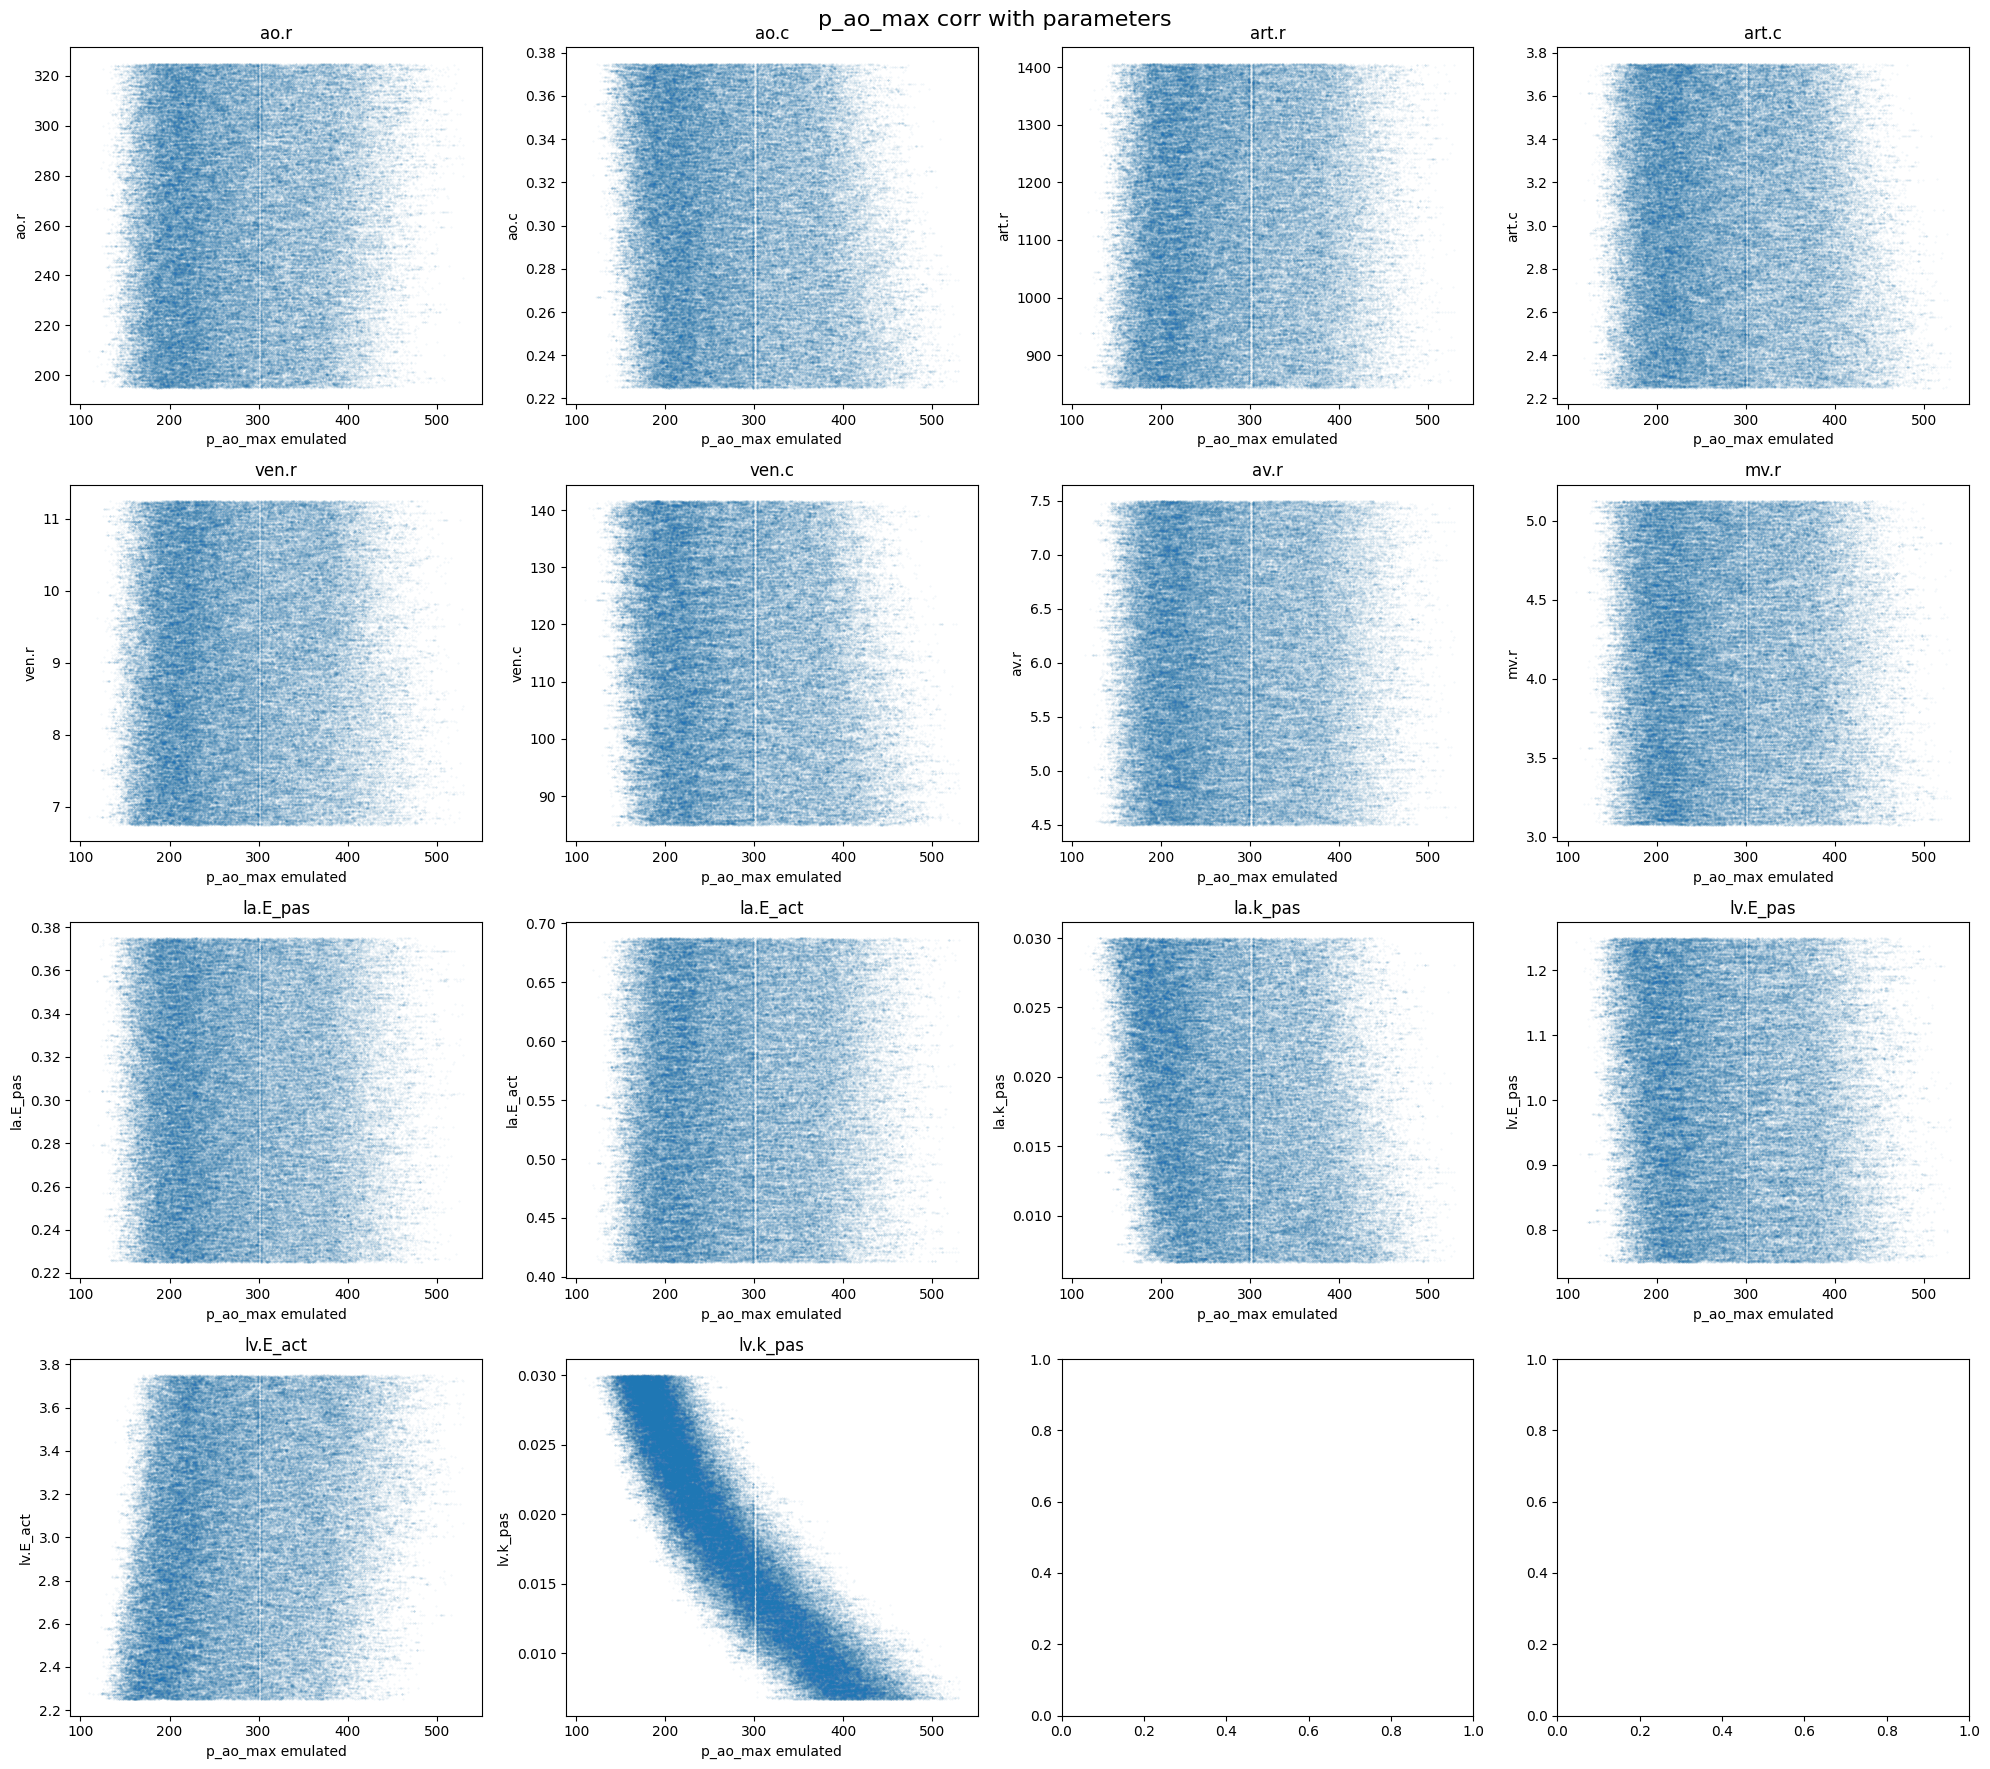

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 18))
axes = axes.flatten()

for i, param_name in enumerate(param_values.columns):
    axes[i].scatter(y_pred_np, param_values[param_name], alpha=0.1, s=0.1)
    axes[i].set_xlabel(f'{output_to_emulate} emulated')
    axes[i].set_ylabel(param_name)
    axes[i].set_title(param_name)

# Add a super title
plt.suptitle(f'{output_to_emulate} corr with parameters', fontsize=16)

plt.tight_layout()
plt.show()
